## Attention Mechanism in Seq2Seq Models

### Introduction
Attention mechanisms in neural networks play a crucial role in sequence-to-sequence (Seq2Seq) models by allowing the decoder to selectively focus on relevant parts of the input sequence. This is particularly important for tasks such as machine translation, where compressing all encoder hidden states into a single context vector leads to information loss.

### The Attention Mechanism

The attention mechanism allows the decoder to focus on different parts of the input sequence at each time step rather than relying on a fixed-length context vector. The attention process follows these steps:

1. Compute alignment scores for each encoder hidden state with respect to the decoder hidden state.
2. Normalize these scores using the softmax function to obtain attention weights.
3. Use the attention weights to compute a weighted sum of encoder hidden states, known as the **context vector**.
4. Use the context vector along with the decoder's previous hidden state to generate the current output.

### Concatenate Attention (Bahdanau Attention)

Concat attention, as proposed by Bahdanau, computes alignment scores by concatenating the decoder's previous hidden state and each encoder hidden state, then passing them through a feed-forward network. The steps are as follows:

#### 1. Compute Alignment Scores

For a given decoder time step $ j $, we compute an alignment score $ e_{ij} $ for each encoder hidden state $ h_{encoder} $ using:

$$
 e_{ij} = \tanh(W_a [h_{decoder}^{j-1} ; h_{encoder}])
$$

where:
- $ W_a $ is a learned weight matrix.
- $ ; $ represents concatenation.

This alignment score determines how well each encoder hidden state "matches" the decoder's previous hidden state.

#### 2. Compute Attention Weights

The alignment scores $ e_{ij} $ are then normalized using the softmax function:

$$
 \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{Tx} \exp(e_{ik})}
$$

where $ \alpha_{ij} $ represents the attention weight assigned to each encoder hidden state.

#### 3. Compute Context Vector

The context vector $ C_j $ is obtained as a weighted sum of encoder hidden states:

$$
 C_j = \sum_{i=1}^{Tx} \alpha_{ij} h_{encoder_i}
$$

#### 4. Update Decoder Hidden State

The decoder uses the context vector $ C_j $ along with its previous hidden state to generate the next output token.

---

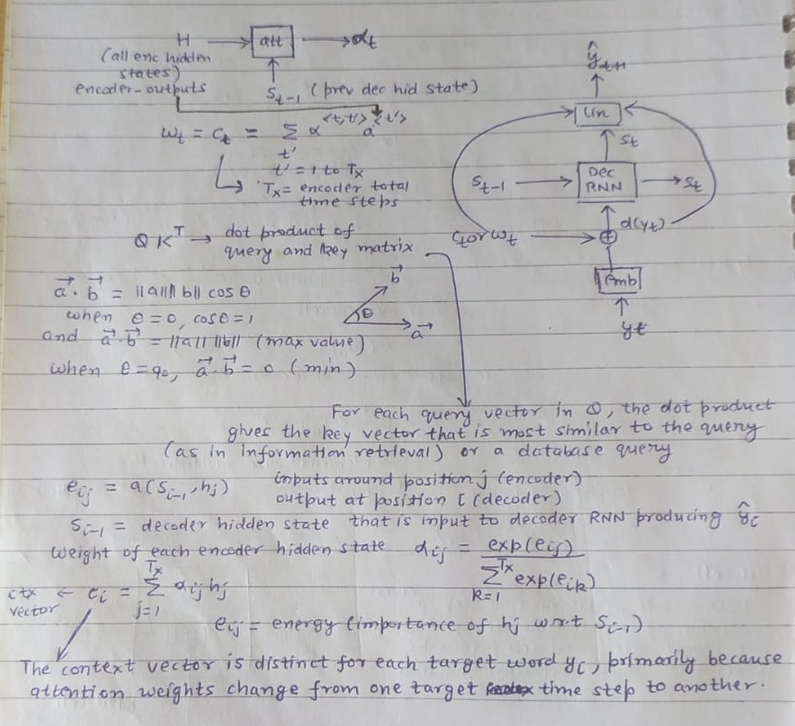

## Encoder-Decoder Architecture with Attention

### Encoder

The **encoder** processes the input sequence and produces a set of hidden states, which represent different levels of abstraction of the input data. These hidden states are then used by the attention mechanism to determine which parts of the input should be attended to at each decoding step.

```python
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout):
        super().__init__()
        
        # Embedding layer to convert input tokens to dense vectors
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Bidirectional GRU to process input sequence in both directions
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        
        # Linear layer to map concatenated bidirectional hidden states to decoder hidden dimension
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        
        # Apply embedding layer
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        
        # Process the input sequence using the bidirectional GRU
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * 2] (since bidirectional)
        # hidden = [n layers * 2, batch size, hidden dim]
        
        # Extract the last hidden states from forward and backward passes
        # hidden [-2, :, : ] is the last hidden state (hidden state at last time step) of the forward RNN
        # hidden [-1, :, : ] is the last hidden state (hidden state at last time step) of the backward RNN
        # initial decoder hidden is final hidden state of the forward and backward RNN passed through a linear layer        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        # hidden = [batch size, decoder hidden dim]
        
        return outputs, hidden
```

### Attention Mechanism

The **attention mechanism** computes a context vector as a weighted sum of encoder hidden states. The attention weights are obtained by:

1. **Concatenating** the decoder's previous hidden state with each encoder hidden state.
2. **Passing the concatenated vectors through a feedforward layer** to compute the alignment score.
3. **Applying softmax** to obtain the attention distribution.
4. **Computing a weighted sum** of encoder hidden states using these attention scores.

```python
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        
        # Linear layer to compute alignment scores
        self.attn_fc = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        
        # Linear layer to condense the alignment scores to a single value
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # Here hidden is the previous decoder hidden state
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # Repeat decoder hidden state across all time steps of encoder. Here 1 means we are not repeating along dim 0 and dim 2 
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        
        # Compute alignment scores
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        
        # Compute attention scores
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        
        return torch.softmax(attention, dim=1)
```

### Decoder

The **decoder** generates output tokens one at a time by attending to relevant encoder hidden states at each step.

```python
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        # Embedding layer
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        
        # GRU to process the input along with context vector
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        
        # Linear layer to generate final output
        self.fc_out = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # Here hidden is the previous decoder hidden state
        # hidden = [batch size, decoder hidden dim]
        # input = [batch size]
        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, output embedding dim]
        
        # Compute attention weights
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        
        # Compute weighted context vector
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        
        # Concatenate weighted context vector with embedded input
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + output embedding dim]
        
        # Pass through GRU
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq len, batch size, decoder hidden dim * n directions] (seq_len = 1 and n directions = 1 for decoder)
        # hidden = [n layers * n directions, batch size, decoder hidden dim]

        # Generate predictions
        output = output.squeeze(0)
        # output = [batch size, decoder hidden dim]
        weighted = weighted.squeeze(0)
        # weighted = [batch size, encoder hidden dim * 2]
        embedded = embedded.squeeze(0)
        # embedded = [batch size, output embedding dim]
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)
```

---

## Summary

- The **encoder** processes the input sequence using a bidirectional GRU.
- The **attention mechanism** computes a weighted sum of encoder hidden states based on alignment scores.
- The **decoder** generates output tokens by attending to relevant encoder hidden states at each time step.
- The attention scores are computed using a concatenation-based approach, followed by a linear transformation and softmax normalization.

This approach significantly improves the ability of sequence-to-sequence models to handle long-range dependencies and varying input lengths.

---